# Classifying Fashion-MNIST

#### Datasets
- `torch.utils.data.Dataset`: Abstract class representing a Dataset, subclasses needs override `__len__`(size of dataset) & `__getitem__` (integer indexing range(0, len(self))
- `torch.utils.data.DataLoader`: Combine a `dataset` and a `sampler`
    - dataset `Dataset`
    - sampler: `Sampler`, defines *the strategy to draw samples*
    
#### Transform
- `torchvision.transforms.Compose(transforms)`: Composes several transforms together

- Transform on PIL Image : `CenterCrop`, `Grayscale`, `Pad`, `RandomResizedCrop`, 
- Transform on torch Tensor: `Normalize`, `LinearTransformation`
- Conversion: `ToPILImage`, `ToTensor`, 
- Generic: `Lambda(function)`
- Functional: 
    - `import torchvision.transforms.functional as TF`
    - `rotate`, `adjust_brightness`, `pad`, `resize`

In [1]:
import torch
from torchvision import datasets, transforms
import helper

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), # convert PIL/ ndarray to tensor
    transforms.Normalize((0.5,), (0.5, )) # (img - mean)/ std
])

In [3]:
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', \
                                 download=True, \
                                 train=True, transform=transform)

In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)

In [5]:
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

In [6]:
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [7]:
image, label = next(iter(trainloader))

In [8]:
image.shape

torch.Size([64, 1, 28, 28])

In [9]:
label

tensor([2, 0, 6, 0, 0, 1, 9, 4, 9, 4, 6, 3, 4, 5, 1, 0, 5, 5, 1, 0, 7, 8, 0, 9,
        7, 9, 8, 0, 9, 8, 1, 9, 8, 9, 6, 5, 1, 7, 5, 4, 9, 2, 4, 9, 5, 0, 5, 0,
        9, 7, 0, 3, 4, 2, 9, 4, 2, 7, 2, 2, 7, 8, 0, 5])

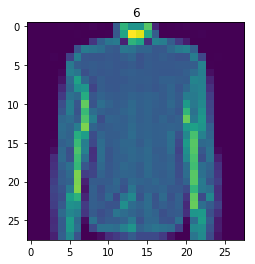

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
img_idx = 10
plt.imshow(image[img_idx, :][0])
plt.title(str(label.numpy()[img_idx]))
plt.show()


### Building the network

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Difference between [log_softmax and softmax](https://discuss.pytorch.org/t/what-is-the-difference-between-log-softmax-and-softmax/11801)
- `log_softmax`: applies `log` after `softmax`: log(softmax(x))
- More efficient

### Train the network

1. Xây dựng model

In [12]:
n_features = 28 * 28
n_classes = 10

In [13]:
class FMNIST_Classifier(nn.Module):
    def __init__(self, n_features, n_classes):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, n_classes)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Dim=1: Dimension for calculate softmax (row)
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

In [14]:
# model = nn.Sequential(
#     nn.Linear(n_features, 128),
#     nn.ReLU(),
#     nn.Linear(128, 32),
#     nn.ReLU(),
#     nn.Linear(32, n_classes),
#     nn.LogSoftmax(dim=1) 
# )
model = FMNIST_Classifier(n_features, n_classes)

2. Định nghĩa hàm Loss và optimizer

In [15]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

3. Cách training

In [16]:
n_epochs = 5

In [17]:
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: 
        images = images.view(images.shape[0], -1) # flatten
        logits = model(images) # forward
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    else:
        print(f"Epoch {epoch + 1}, loss: {epoch_loss / len(trainloader)}")
        
    

Epoch 1, loss: 0.5328869107626141
Epoch 2, loss: 0.3916099741578356
Epoch 3, loss: 0.35293779013825377
Epoch 4, loss: 0.32597592670812026
Epoch 5, loss: 0.3071900259600138


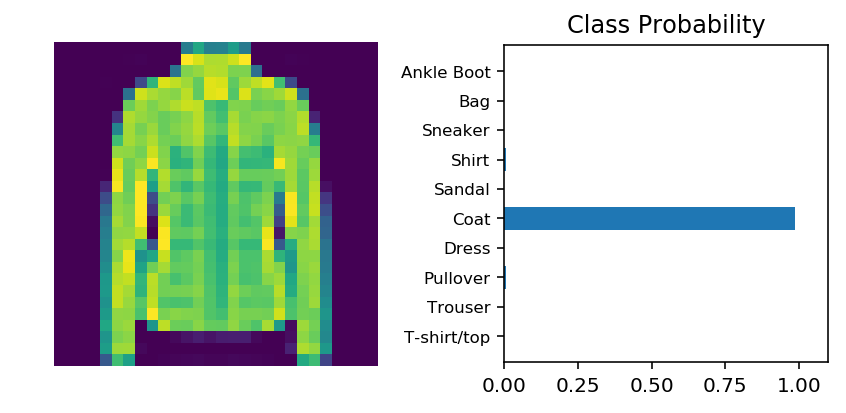

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper

# Test out your network!

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# TODO: Calculate the class probabilities (softmax) for img
with torch.no_grad():
    logps = model(img)
ps = torch.exp(logps)

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps, version='Fashion')